# Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Utils

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time[start:end], series_num[start:end], format)
    else:
        plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

In [4]:
def trend(time, slope=0):
    return slope * time

In [5]:
def seasonal_pattern(season_time):
    data_pattern = np.where(season_time <0.4,
                            np.cos(season_time * 2 * np.pi),
                            1 / np.exp(3 * season_time))
    return data_pattern

In [6]:
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)
    return data_pattern

In [7]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level
    return noise

# Generate the synthetic data

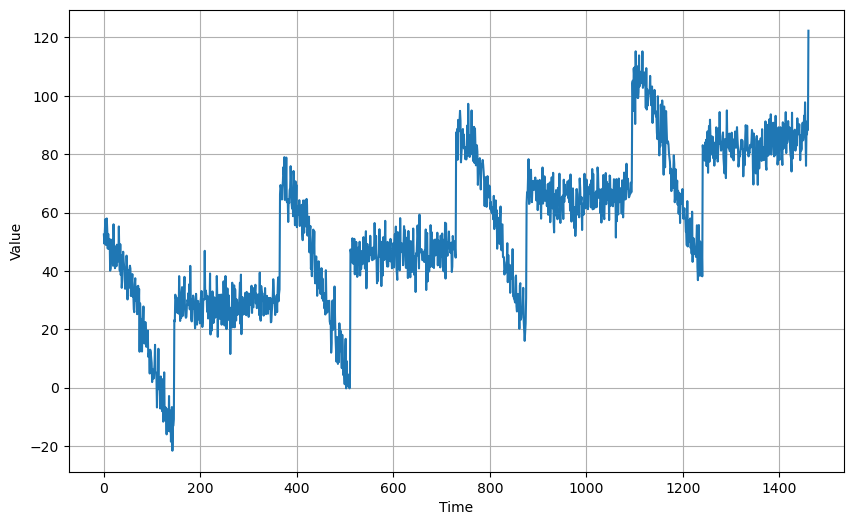

In [8]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

series += noise(time, noise_level, seed=42)

plot_series(time, series)

# Split the dataset

In [9]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# Prepare features and labels

In [10]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(1)

    return dataset

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2025-03-31 17:33:26.147290: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20, 1)
shape of label: (32, 1)


2025-03-31 17:33:26.850077: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-31 17:33:26.850604: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Build the model

In [14]:
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

# Tune the learning rate

In [16]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 76.5128 - learning_rate: 1.0000e-08
Epoch 2/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 75.4222

2025-03-31 17:38:08.939822: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/pndx/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 73.9180 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 70.6104 - learning_rate: 1.2589e-08
Epoch 4/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 68.5672

2025-03-31 17:38:09.650898: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 67.0329 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 63.2684 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 59.3772 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 55.3955 - learning_rate: 1.9953e-08
Epoch 8/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 52.6923

2025-03-31 17:38:11.018813: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 51.3355 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 47.1938 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 42.9538 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 38.5912 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 34.0778 - learning_rate: 3.5481e-08
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 29.3788 - learning_rate: 3.9811e-08
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 24.4762 - learning_rate: 4.4668e-08
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.4443 - learning_rate: 5.0119e-08
Epoch 16/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.3030

2025-03-31 17:38:13.752393: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.1177 - learning_rate: 5.6234e-08
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12.5364 - learning_rate: 6.3096e-08
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 11.2695 - learning_rate: 7.0795e-08
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.6730 - learning_rate: 7.9433e-08
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.2887 - learning_rate: 8.9125e-08
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.9551 - learning_rate: 1.0000e-07
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.6309 - learning_rate: 1.1220e-07
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3069 - learning_rate: 1.2589e-07
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9807 - learning_rate: 1.4125e-07
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6555 - learning_rate: 1.5849e-07
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/

2025-03-31 17:38:19.093361: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6180 - learning_rate: 3.5481e-07
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4094 - learning_rate: 3.9811e-07
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2342 - learning_rate: 4.4668e-07
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0829 - learning_rate: 5.0119e-07
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9490 - learning_rate: 5.6234e-07
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8268 - learning_rate: 6.3096e-07
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7195 - learning_rate: 7.0795e-07
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6305 - learning_rate: 7.9433e-07
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5557 - learning_rate: 8.9125e-07
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4955 - learning_rate: 1.0000e-06
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

2025-03-31 17:38:30.108153: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3298 - learning_rate: 1.4125e-05
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2897 - learning_rate: 1.5849e-05
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3641 - learning_rate: 1.7783e-05
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7517 - learning_rate: 1.9953e-05
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8550 - learning_rate: 2.2387e-05
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2389 - learning_rate: 2.5119e-05
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9731 - learning_rate: 2.8184e-05
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3373 - learning_rate: 3.1623e-05
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1733 - learning_rate: 3.5481e-05
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4147 - learning_rate: 3.9811e-05
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

(1e-08, 0.001, 0.0, 30.0)

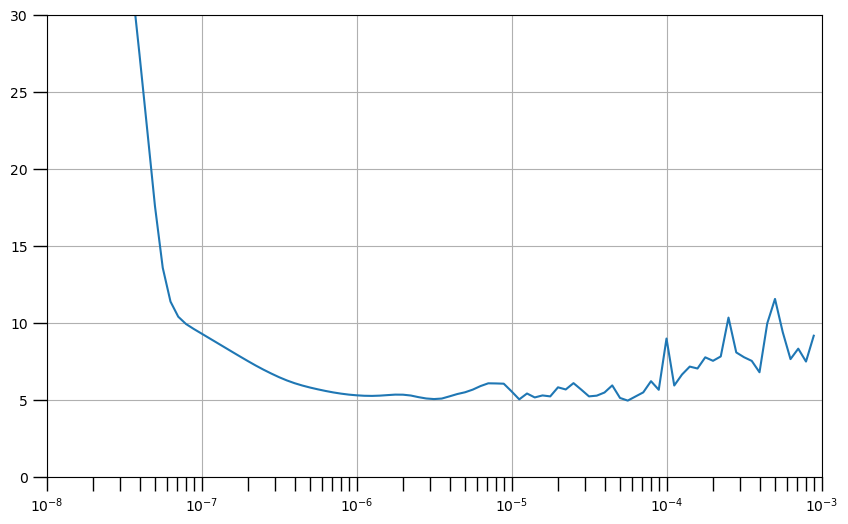

In [17]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

# Train the model

In [26]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

learning_rate = 1e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(dataset, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 33.1454 - mae: 33.6425
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.1917 - mae: 15.6862
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.2086 - mae: 11.6977
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9879 - mae: 9.4734
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.7897 - mae: 8.2736
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3420 - mae: 7.8258
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1494 - mae: 7.6365
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0250 - mae: 7.5124
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9229 - mae: 7.4071
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8326 - mae: 7.3151
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.7505 - mae: 7.2322
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6745 - mae: 7.1552
Epoch 13/100
31/31 

# Model prediction

In [27]:
def model_forecast(model, series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset, verbose=0)
    return forecast

/home/pndx/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


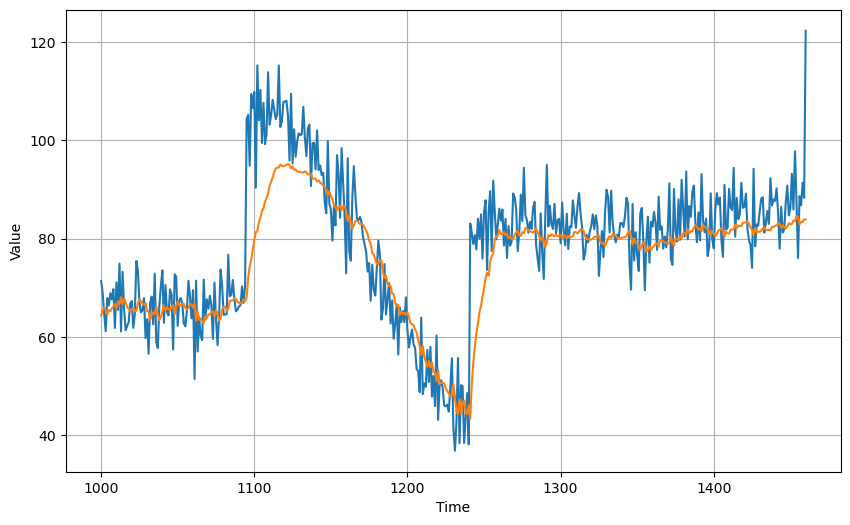

In [28]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [29]:
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

71.36382
5.9650555


# Validation Set while Training

In [30]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [32]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])
learning_rate = 2e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, validation_data=val_set)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 14.8680 - mae: 15.3616 - val_loss: 22.1251 - val_mae: 22.6228
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.8869 - mae: 9.3721 - val_loss: 14.1014 - val_mae: 14.5943
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4427 - mae: 7.9218 - val_loss: 12.0056 - val_mae: 12.4962
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1084 - mae: 7.5917 - val_loss: 11.0638 - val_mae: 11.5558
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8679 - mae: 7.3458 - val_loss: 10.5357 - val_mae: 11.0260
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6740 - mae: 7.1547 - val_loss: 10.1118 - val_mae: 10.6026
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5130 - mae: 6.9964 - val_loss: 9.7409 - val_mae: 10.2311
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.3642 - mae: 6.8497 - val_loss: 9.4587 - val_mae: 9.9471
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s